In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py


In [2]:
!pwd

/home/breuer/ventilation_system/preplanning/src/preplanning/postprocessing


In [3]:
os.chdir("../../../")


In [4]:
plt.style.use("FST_bw.mplstyle")

In [5]:
# Specify the directory containing the .h5 files
directory = "new_solutions/real_GPZ/preplanning/varying_lc/"

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".h5"):
        file_path = os.path.join(directory, filename)
        
        try:
            with h5py.File(file_path, 'r') as h5_file:
                # Check if 'comment' dataset exists
                if "Comment" in h5_file:
                    comment_data = h5_file["Comment"][()]
                    print(f"File: {filename}")
                    print(f"Comment: {comment_data.decode() if isinstance(comment_data, bytes) else comment_data}\n")
                else:
                    print(f"File: {filename} - No 'comment' dataset found.\n")
        except Exception as e:
            print(f"Error reading {filename}: {e}")


File: 39d186e0-140b-46f0-b02a-c28ea5a58ef0.h5
Comment: distributednumber of load cases: 11

File: a6f609fc-29e4-461a-9e23-626e4597b298.h5
Comment: distributednumber of load cases: 2

File: 61b8ee2e-7a53-4f78-8ca0-003cefb42310.h5
Comment: distributednumber of load cases: 5

File: 8a12ddc0-0502-4bda-9b5f-94322a93c4ff.h5
Comment: distributednumber of load cases: 1

File: bf1867c9-3e72-4380-9667-ba860e2f2557.h5
Comment: distributednumber of load cases: 8

File: 196bfd45-9b18-49e0-8be6-63726cf9ecea.h5
Comment: distributednumber of load cases: 4

File: 44c5b861-1fe0-40fe-ac2a-508668a435cc.h5
Comment: distributednumber of load cases: 9

File: 12d2973a-9b79-4948-89d8-053f29509e34.h5
Comment: distributednumber of load cases: 7

File: 1c226ccb-fe9c-4bc2-814a-ce24d6651ff7.h5
Comment: distributednumber of load cases: 3

File: 39f62c7a-6115-489f-8b1a-e04867efff9f.h5
Comment: distributednumber of load cases: 6

File: acd88843-e796-4a67-83a2-2961015b429f.h5
Comment: distributednumber of load cases: 1

In [6]:
import h5py
import os

def extract_h5_data(folder_path):

    excluded_folders = {"old", "with_max_load_case_but_no_underestimation_of_ploss", "without_all_VFC_or_all_fan_constraint_no_max_load_case"}

    data_dict = {}

    # Iterate through all files in the folder
    # for file_name in os.listdir(folder_path):
    for root, dirs, files in os.walk(folder_path):
        dirs[:] = [d for d in dirs if d not in excluded_folders]
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if file_path.endswith(".h5"):  # Ensure it's an HDF5 file
                # file_path = os.path.join(folder_path, file_name)
                try:
                    with h5py.File(file_path, "r") as h5_file:
                        if "Expression" in h5_file["Optimisation Components"]:  # Check if 'expression' group exists
                            expression_group = h5_file["Optimisation Components"]["Expression"]
                            invest_costs = None
                            power_consumption = None
                            exact_power_consumption = None
                            duct_costs, vfc_costs, fan_costs = None, None, None
                            duct_volume = None

                            # Access the subdatasets under 'expression'

                            # Extract invest_costs if available
                            if "total_invest_costs" in expression_group:
                                dataset = expression_group["total_invest_costs"]
                                invest_costs = dataset[0]["value"]

                            # Extract operating_costs if available
                            if "fan_power_consumption" in expression_group:
                                dataset = expression_group["fan_power_consumption"]
                                power_consumption = dataset[0]["value"]

                            if "fan_energy_costs" in expression_group:
                                dataset = expression_group["fan_energy_costs"]
                                fan_energy_costs = dataset[0]["value"]

                            if "Exact Power Consumption" in h5_file["Postprocessing"]:
                                dataset = h5_file["Postprocessing"]["Exact Power Consumption" ]
                                exact_power_consumption = dataset[()]

                            if "total_duct_costs" in expression_group:
                                dataset = expression_group["total_duct_costs"]
                                duct_costs = dataset[0]["value"]

                            if "total_vfc_costs" in expression_group:
                                dataset = expression_group["total_vfc_costs"]
                                vfc_costs = dataset[0]["value"]

                            if "total_fan_costs" in expression_group:
                                dataset = expression_group["total_fan_costs"]
                                fan_costs = dataset[0]["value"]

                            if "duct_volume" in expression_group:
                                dataset = expression_group["duct_volume"]
                                duct_volume = dataset[0]["value"]

                            if "fan_ind_purchase" in h5_file["Optimisation Components"]["Variable"]:
                                dataset = h5_file["Optimisation Components"]["Variable"]["fan_ind_purchase"][:]
                                fan_ind_purchase = dict(zip([x.decode("utf-8") for x in dataset["fan_set"]], dataset["value"]))


                            if "Problem Definition" in h5_file:
                                lb = h5_file["Problem Definition"]["Lower bound"][()]
                                ub = h5_file["Problem Definition"]["Upper bound"][()]
                                gap = (ub-lb)/lb
                            
                            if "Number of Load Cases" in h5_file:
                                n_lc = h5_file["Number of Load Cases"][()]

                            # Store values in dictionary
                            data_dict[file_name] = {
                                "invest_costs": invest_costs,
                                "power_consumption": power_consumption,
                                "exact_power_consumption": exact_power_consumption,
                                "duct_costs": duct_costs,
                                "vfc_costs": vfc_costs,
                                "fan_costs": fan_costs,
                                "duct_volume": duct_volume,
                                "fan_ind_purchase": fan_ind_purchase,
                                "fan_energy_costs": fan_energy_costs,
                                "opt_gap": gap,
                                "n_load_cases": n_lc,
                            }

                except Exception as e:
                    print(f"Error processing {file_name}: {e}")

    return data_dict

folder = "new_solutions/real_GPZ/preplanning/"

result_dict = extract_h5_data(folder + "varying_lc")


In [7]:
result_dict = {key: value for key,value in result_dict.items() if value["n_load_cases"] <= 8}

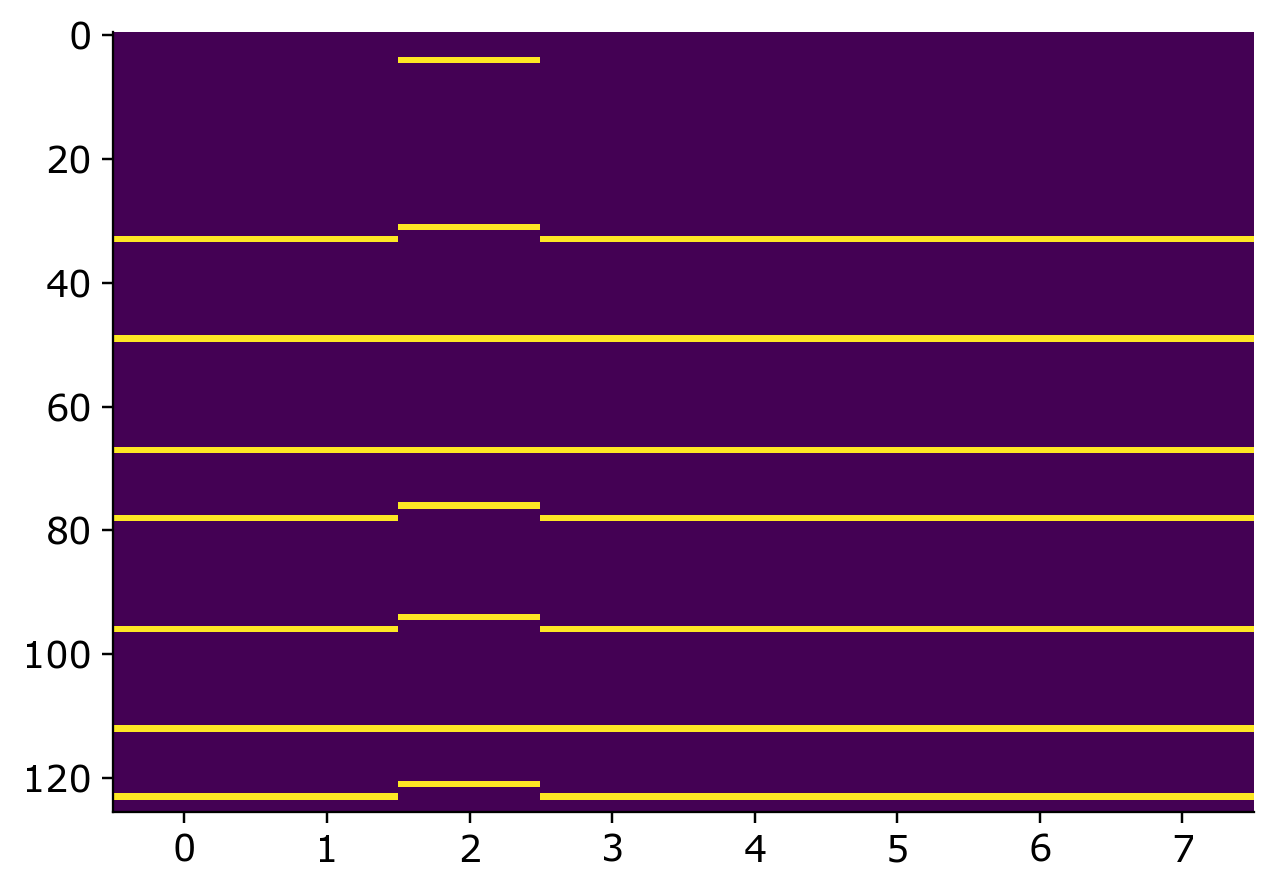

In [8]:
from collections import defaultdict

def transpose_dict_of_dicts(data):
    result = defaultdict(list)
    for outer_key in data:
        for inner_key, value in data[outer_key]["fan_ind_purchase"].items():
            result[inner_key].append(value)
    return dict(result)

transposed = transpose_dict_of_dicts(result_dict)
plt.imshow(np.array([x for x in transposed.values()]), aspect="auto")


# yticks = result_list[-1]['be80e77b-daee-4cfd-b042-c524aa503d3f.h5']["fan_ind_purchase"].keys()

# _ = plt.yticks(range(len(yticks)), yticks, fontsize=2)

In [9]:
def process_dicts(dict_from_h5):
    # Get all keys (like 'invest_costs', etc.) from one of the entries
    value_keys = list(next(iter(dict_from_h5.values())).keys())

    # For each key, collect all values across the dicts
    collected = {key: [entry[key] for entry in dict_from_h5.values()] for key in value_keys}

    # Sort by the first metric (e.g., 'invest_costs')
    sort_key = value_keys[0]
    sorted_indices = np.argsort(collected[sort_key])

    # Build a sorted output dictionary
    sorted_dict = {
        key: np.array(values)[sorted_indices]
        for key, values in collected.items()
    }

    return sorted_dict

standard_dict = process_dicts(result_dict)

<ErrorbarContainer object of 3 artists>

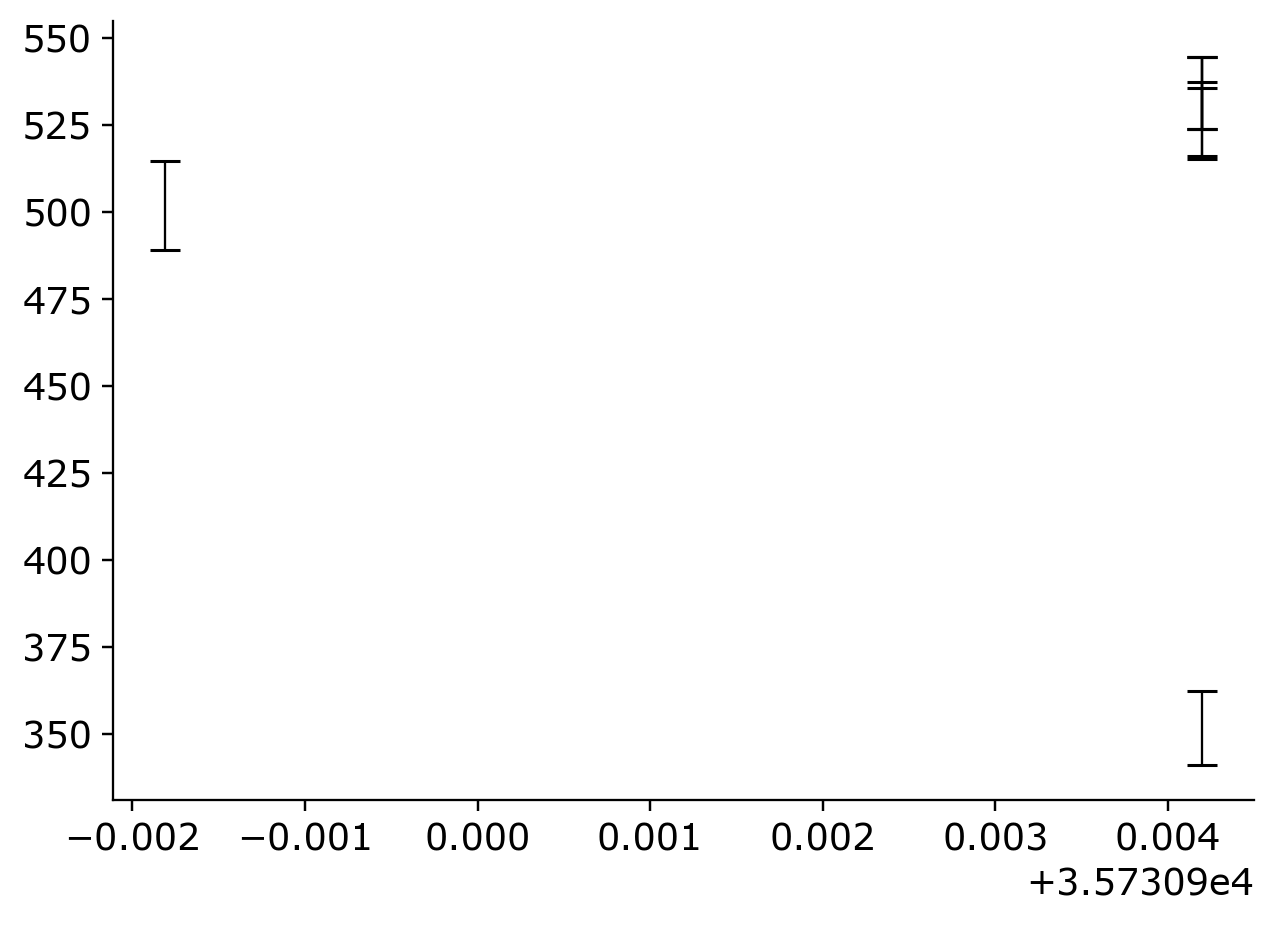

In [10]:

real_power_consumption_error = []
for idx,x in enumerate(standard_dict["exact_power_consumption"]):
    if idx > 0:
        if x > standard_dict["exact_power_consumption"][idx-1]:
            x = standard_dict["exact_power_consumption"][idx-1]
    real_power_consumption_error.append(x)

real_power_consumption_error =  standard_dict["exact_power_consumption"]# np.array(real_power_consumption_error)

errorbar = np.array([y-x for x,y in zip(standard_dict["power_consumption"], real_power_consumption_error)])

filtered_errorbar = np.where(errorbar<0,np.nan,errorbar)
filtered_invest_costs = np.where(errorbar<0,np.nan,standard_dict["invest_costs"])
filtered_power_consumption = np.where(errorbar<0,np.nan,standard_dict["power_consumption"])
error_0 = np.zeros_like(filtered_errorbar)

plt.errorbar(filtered_invest_costs, filtered_power_consumption, yerr=[error_0,filtered_errorbar], fmt='o', markersize=0, capsize=5)


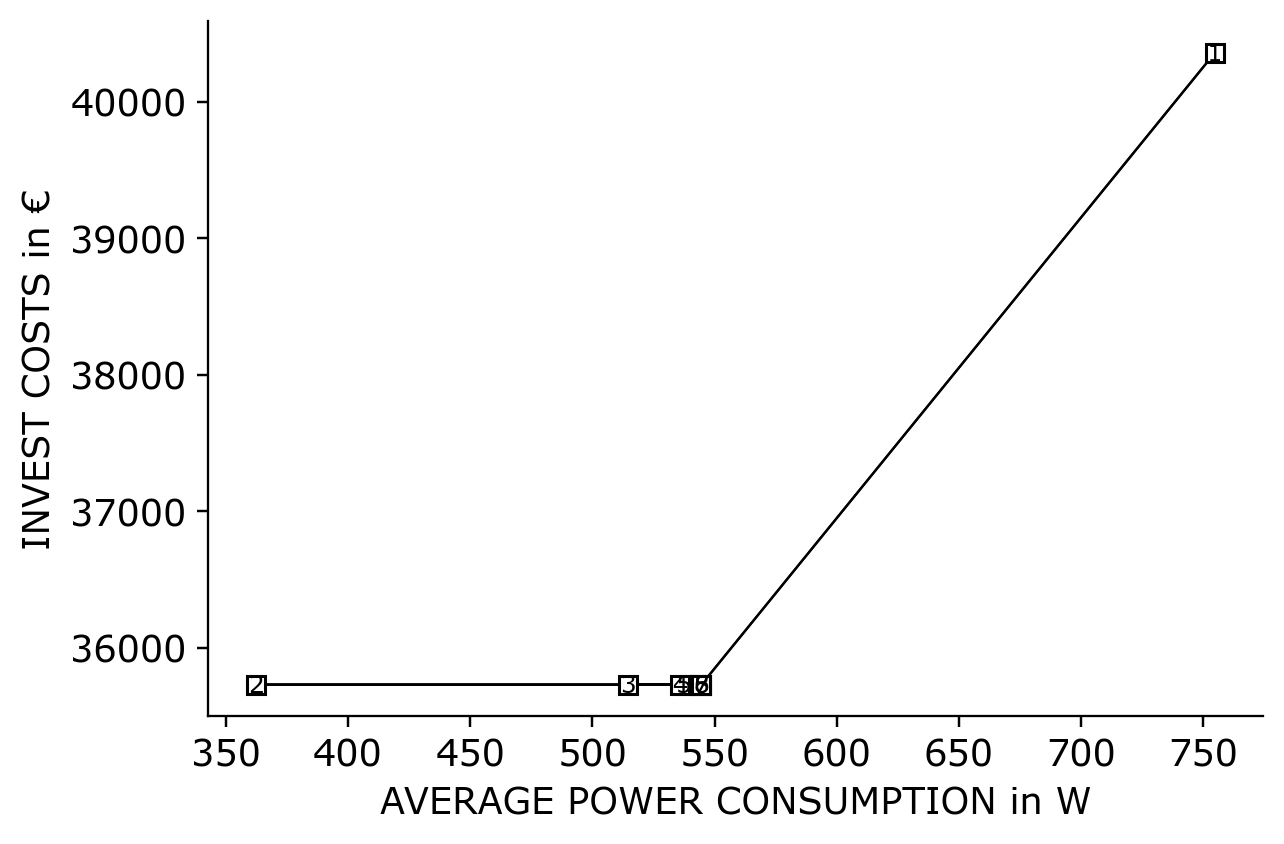

In [11]:
markerstyle = ["s","o","d","v","^","P","*"]

fig,ax = plt.subplots(figsize=(6,4))


plt.plot(standard_dict["exact_power_consumption"],standard_dict["invest_costs"], "-", color="k", markeredgecolor="k")

plt.plot(standard_dict["exact_power_consumption"],standard_dict["invest_costs"], color="k", marker="s",markerfacecolor="white", markeredgecolor="k")

for x, y, label in zip(standard_dict["exact_power_consumption"],
                       standard_dict["invest_costs"],
                       standard_dict["n_load_cases"]):  # replace `your_labels` with the actual text list
    plt.text(x, y, str(label),
             color='k', fontsize=8,
             ha='center', va='center')

plt.ylabel("INVEST COSTS in €")
plt.xlabel("AVERAGE POWER CONSUMPTION in W")

# plt.xlim(left=0)
# plt.ylim(bottom=0)
fig.tight_layout()
# save_fig_as_emf(fig, "plots/fan2025/pareto_front_all.emf")



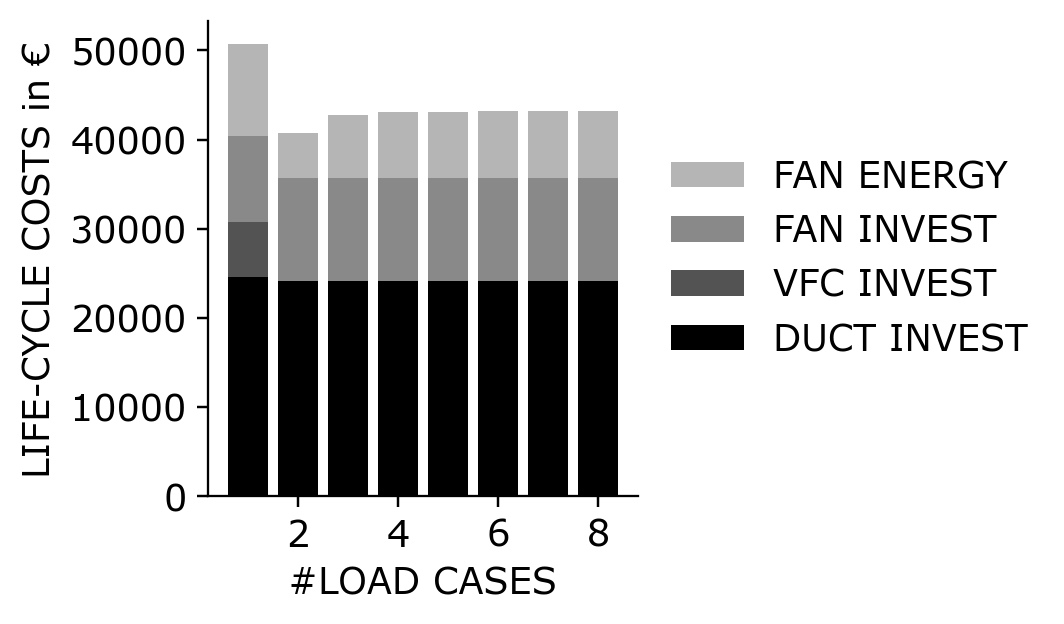

In [14]:
fig, ax = plt.subplots(figsize=(5,3))

len_n = len(standard_dict["vfc_costs"])
standard_dict["exact_fan_energy_costs"] = standard_dict["fan_energy_costs"] * standard_dict["exact_power_consumption"]/standard_dict["power_consumption"]
# ax.bar(standard_dict["n_load_cases"],(standard_dict["exact_fan_energy_costs"] + standard_dict["invest_costs"])*(1+standard_dict["opt_gap"]), color=[0.2]*3)
ax.bar(standard_dict["n_load_cases"],standard_dict["duct_costs"], label="DUCT INVEST")
ax.bar(standard_dict["n_load_cases"],standard_dict["vfc_costs"],bottom=standard_dict["duct_costs"], label="VFC INVEST")
ax.bar(standard_dict["n_load_cases"],standard_dict["fan_costs"],bottom=standard_dict["duct_costs"] + standard_dict["vfc_costs"], label="FAN INVEST")
ax.bar(standard_dict["n_load_cases"],standard_dict["exact_fan_energy_costs"],bottom=standard_dict["duct_costs"] + standard_dict["vfc_costs"]+standard_dict["fan_costs"], label="FAN ENERGY")

ax.set_ylabel("LIFE-CYCLE COSTS in €")
ax.set_xlabel("#LOAD CASES")


ax.set_xticks([2,4,6,8])

handles, labels = ax.get_legend_handles_labels()
custom_order = [3, 2, 1, 0]  # Index-Reihenfolge: FAN ENERGY, FAN INVEST, VFC INVEST, DUCT INVEST
ax.legend([handles[i] for i in custom_order], [labels[i] for i in custom_order],
          loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

fig.tight_layout()


fig.savefig("plots/full_paper/bar_chart_varying_load_cases.svg")
fig.savefig("plots/full_paper/bar_chart_varying_load_cases.pdf")
fig.savefig("plots/full_paper/bar_chart_varying_load_cases.png")

In [35]:
standard_dict["n_load_cases"]

array([3, 5, 8, 2, 7, 4, 6, 1])

In [34]:
standard_dict["fan_energy_costs"]

array([ 6717.58059496,  7088.55574582,  7193.18750923,  4683.18147187,
        7193.085657  ,  7076.26504551,  7193.00827616, 43362.98512528])

In [24]:
print(labels, handles)
print(*sorted(zip(labels, handles), key=lambda t: t[0]))

('DUCT INVEST', 'FAN ENERGY', 'FAN INVEST', 'VFC INVEST') (<BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>, <BarContainer object of 8 artists>)
('DUCT INVEST', <BarContainer object of 8 artists>) ('FAN ENERGY', <BarContainer object of 8 artists>) ('FAN INVEST', <BarContainer object of 8 artists>) ('VFC INVEST', <BarContainer object of 8 artists>)


In [20]:
handles, labels

((<BarContainer object of 8 artists>,
  <BarContainer object of 8 artists>,
  <BarContainer object of 8 artists>,
  <BarContainer object of 8 artists>),
 ('DUCT INVEST', 'FAN ENERGY', 'FAN INVEST', 'VFC INVEST'))